In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

2023-03-13 22:39:51.003544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 22:39:51.201120: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-13 22:39:51.232491: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cat/.local/lib/python3.9/site-packages/cv2/../../lib64:
2023-03-13 22:39:51.2

In [3]:
x_train_dir = os.path.join("./dataset/images/", 'training')
x_valid_dir = os.path.join("./dataset/images/", 'validation')
x_test_dir = os.path.join("./dataset/images/", 'testing')

y_train_dir = os.path.join("./dataset/annotations/", 'training')
y_valid_dir = os.path.join("./dataset/annotations/", 'validation')
y_test_dir = os.path.join("./dataset/annotations/", 'testing')

In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['void','keyway']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 1)
        
        # we only care about blue channel for label
        blue, green, red = cv2.split(mask)
        mask = cv2.merge([blue])
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

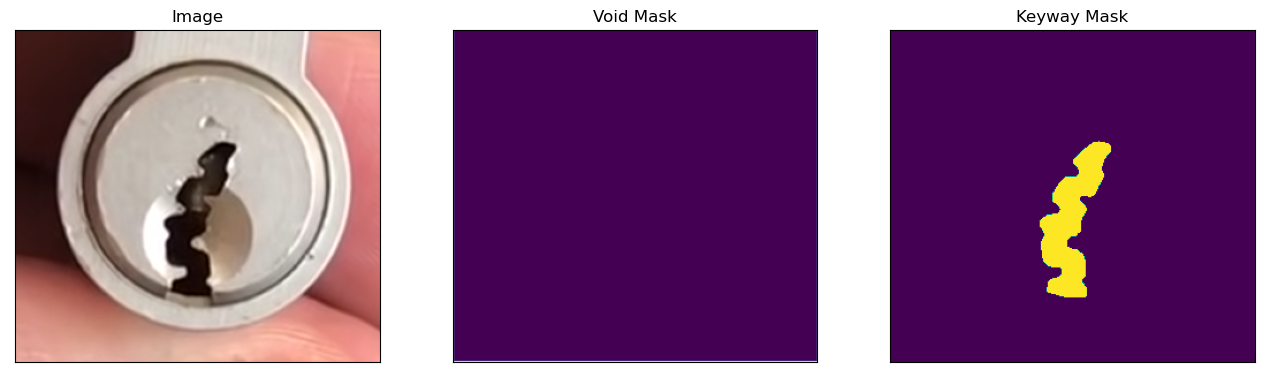

In [5]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['void','keyway'])

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    void_mask=mask[..., 0].squeeze(),
    keyway_mask=mask[..., 1].squeeze()
)

In [6]:
# define heavy augmentations
def get_training_augmentation():
    train_transform = [
        A.ShiftScaleRotate(p=1),
        A.RandomBrightnessContrast(p=0.8),
        A.LongestMaxSize(512),
        A.PadIfNeeded(256, 256),
        A.RandomCrop(width=256, height=256),
        
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.LongestMaxSize(512),
        A.PadIfNeeded(256, 256),
        A.RandomCrop(width=256, height=256),
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)


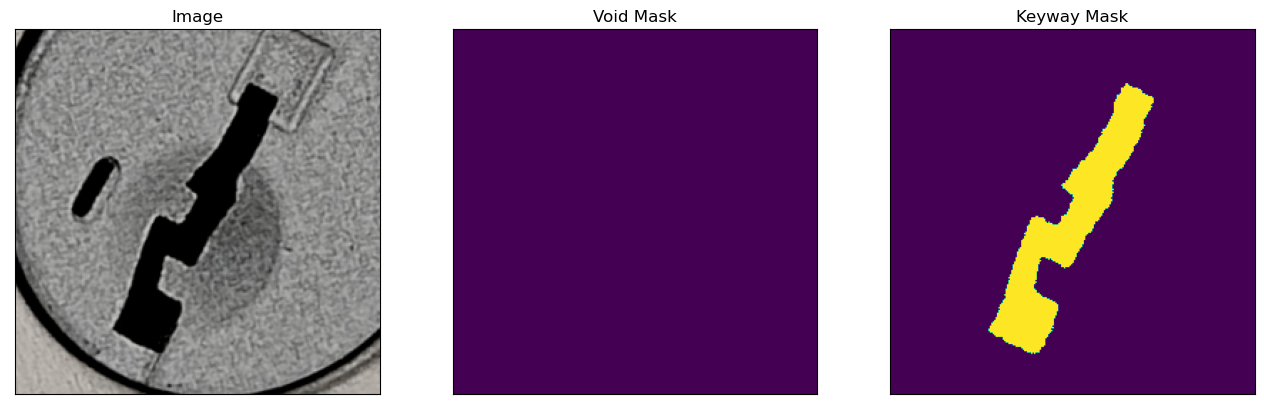

In [7]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['void', 'keyway'], augmentation=get_training_augmentation())

image, mask = dataset[3] # get some sample
visualize(
    image=image, 
    void_mask=mask[..., 0].squeeze(),
    keyway_mask=mask[..., 1].squeeze(),
)

In [9]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [10]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [11]:
BACKBONE = 'resnet18'
BATCH_SIZE = 4
CLASSES = ['keyway']
LR = 0.0001
EPOCHS = 100

preprocess_input = sm.get_preprocessing(BACKBONE)

In [12]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

2023-03-13 22:40:21.681224: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cat/.local/lib/python3.9/site-packages/cv2/../../lib64:
2023-03-13 22:40:21.681245: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-13 22:40:21.681267: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iris): /proc/driver/nvidia/version does not exist
2023-03-13 22:40:21.681813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropr

In [13]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [14]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [13]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks,
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/100
33/33 [==============================] - 69s 2s/step - loss: 1.0096 - iou_score: 0.1312 - f1-score: 0.2277 - val_loss: 1.0714 - val_iou_score: 0.1211 - val_f1-score: 0.2018 - lr: 1.0000e-04
Epoch 2/100
33/33 [==============================] - 55s 2s/step - loss: 0.9130 - iou_score: 0.2970 - f1-score: 0.4470 - val_loss: 1.0192 - val_iou_score: 0.1675 - val_f1-score: 0.2632 - lr: 1.0000e-04
Epoch 3/100
33/33 [==============================] - 53s 2s/step - loss: 0.8762 - iou_score: 0.3709 - f1-score: 0.5288 - val_loss: 1.0341 - val_iou_score: 0.1692 - val_f1-score: 0.2693 - lr: 1.0000e-04
Epoch 4/100
33/33 [==============================] - 51s 2s/step - loss: 0.8251 - iou_score: 0.5103 - f1-score: 0.6565 - val_loss: 0.8871 - val_iou_score: 0.2726 - val_f1-score: 0.3899 - lr: 1.0000e-04
Epoch 5/100
33/33 [==============================] - 53s 2s/step - loss: 0.7622 - iou_score: 0.6069 - f1-score: 0.7446 - val_loss: 0.8478 - val_iou_score: 0.4580 - val_f1-score: 0.5825 - lr: 1

33/33 [==============================] - 51s 2s/step - loss: 0.0882 - iou_score: 0.8991 - f1-score: 0.9466 - val_loss: 0.1588 - val_iou_score: 0.8809 - val_f1-score: 0.9183 - lr: 1.0000e-05
Epoch 42/100
33/33 [==============================] - 56s 2s/step - loss: 0.1047 - iou_score: 0.8787 - f1-score: 0.9341 - val_loss: 0.0861 - val_iou_score: 0.9159 - val_f1-score: 0.9557 - lr: 1.0000e-05
Epoch 43/100
33/33 [==============================] - 54s 2s/step - loss: 0.0878 - iou_score: 0.8996 - f1-score: 0.9467 - val_loss: 0.2053 - val_iou_score: 0.9154 - val_f1-score: 0.9542 - lr: 1.0000e-05
Epoch 44/100
33/33 [==============================] - 65s 2s/step - loss: 0.0847 - iou_score: 0.9031 - f1-score: 0.9488 - val_loss: 0.0866 - val_iou_score: 0.9031 - val_f1-score: 0.9473 - lr: 1.0000e-05
Epoch 45/100
33/33 [==============================] - 63s 2s/step - loss: 0.0908 - iou_score: 0.8959 - f1-score: 0.9435 - val_loss: 0.1489 - val_iou_score: 0.8959 - val_f1-score: 0.9421 - lr: 1.0000e-0

33/33 [==============================] - 53s 2s/step - loss: 0.0831 - iou_score: 0.9015 - f1-score: 0.9476 - val_loss: 0.1673 - val_iou_score: 0.9011 - val_f1-score: 0.9446 - lr: 1.0000e-07
Epoch 82/100
33/33 [==============================] - 50s 2s/step - loss: 0.0783 - iou_score: 0.9079 - f1-score: 0.9514 - val_loss: 0.1454 - val_iou_score: 0.9320 - val_f1-score: 0.9641 - lr: 1.0000e-07
Epoch 83/100
33/33 [==============================] - 54s 2s/step - loss: 0.0708 - iou_score: 0.9172 - f1-score: 0.9567 - val_loss: 0.1578 - val_iou_score: 0.8857 - val_f1-score: 0.9205 - lr: 1.0000e-07
Epoch 84/100
33/33 [==============================] - 54s 2s/step - loss: 0.0769 - iou_score: 0.9084 - f1-score: 0.9516 - val_loss: 0.2570 - val_iou_score: 0.8523 - val_f1-score: 0.8841 - lr: 1.0000e-07
Epoch 85/100
33/33 [==============================] - 50s 2s/step - loss: 0.0820 - iou_score: 0.9059 - f1-score: 0.9503 - val_loss: 0.1519 - val_iou_score: 0.9291 - val_f1-score: 0.9625 - lr: 1.0000e-0

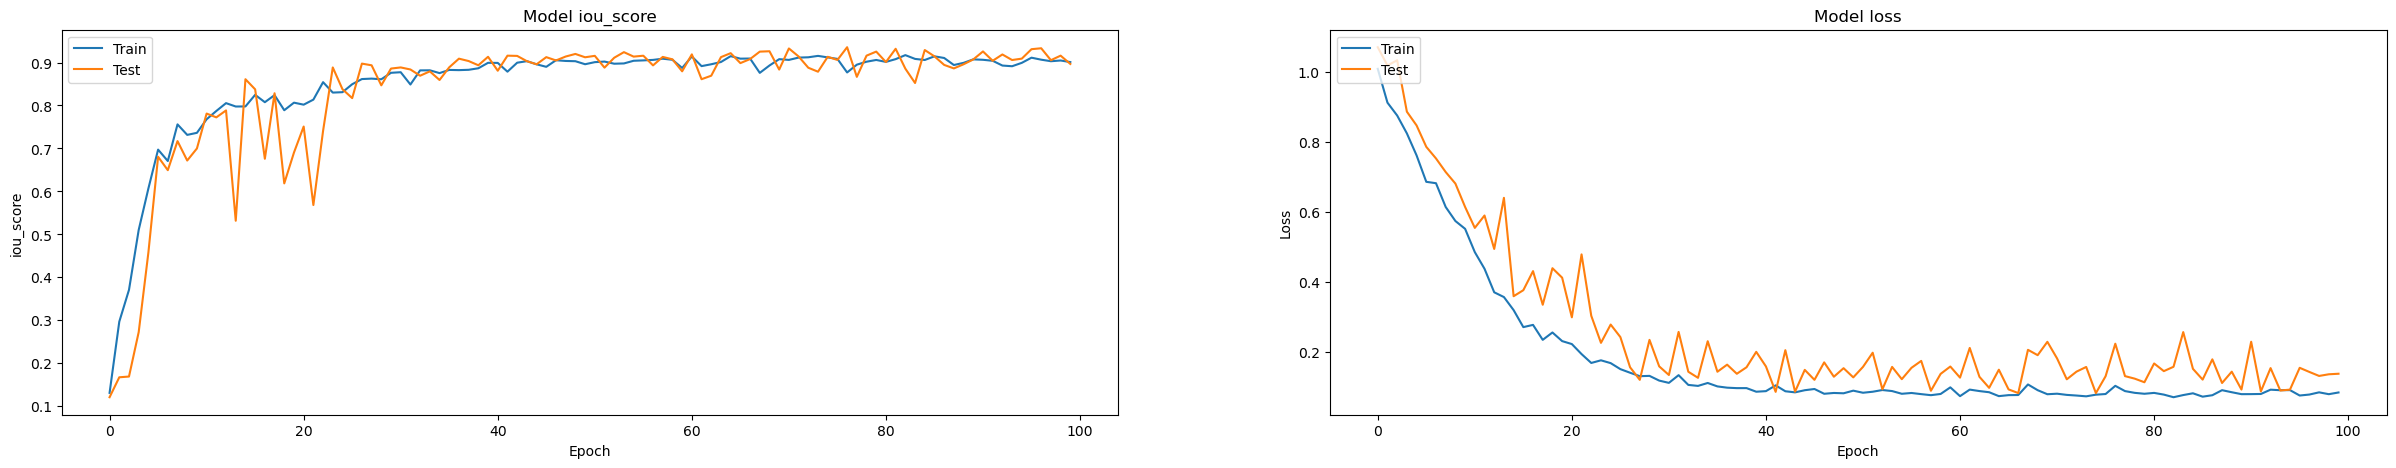

In [14]:


# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



In [18]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [19]:


# load best weights
model.load_weights('best_model.h5') 



In [20]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/tmp/ipykernel_71454/3518042878.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_dataloader)


Loss: 0.1576
mean iou_score: 0.8795
mean f1-score: 0.91406


1/1 [==============================] - 0s 332ms/step


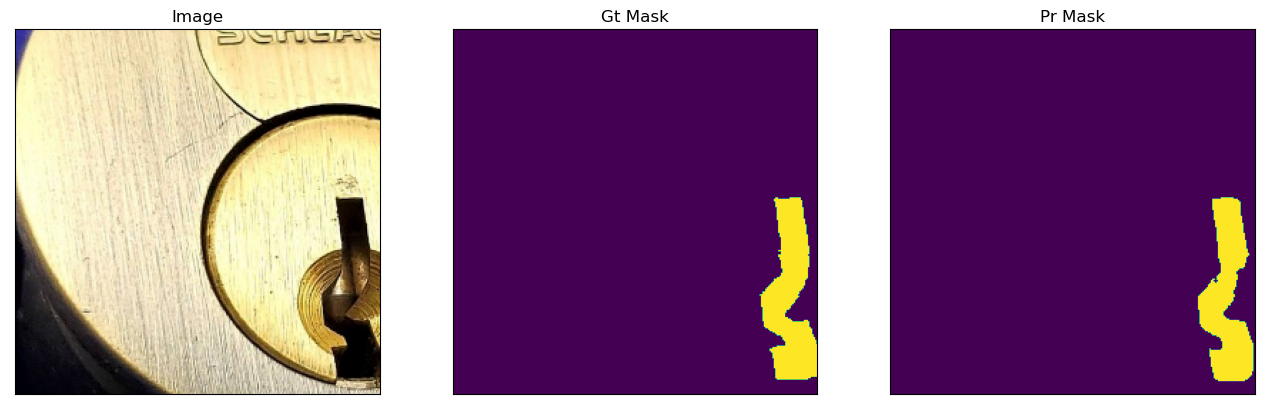

1/1 [==============================] - 0s 79ms/step


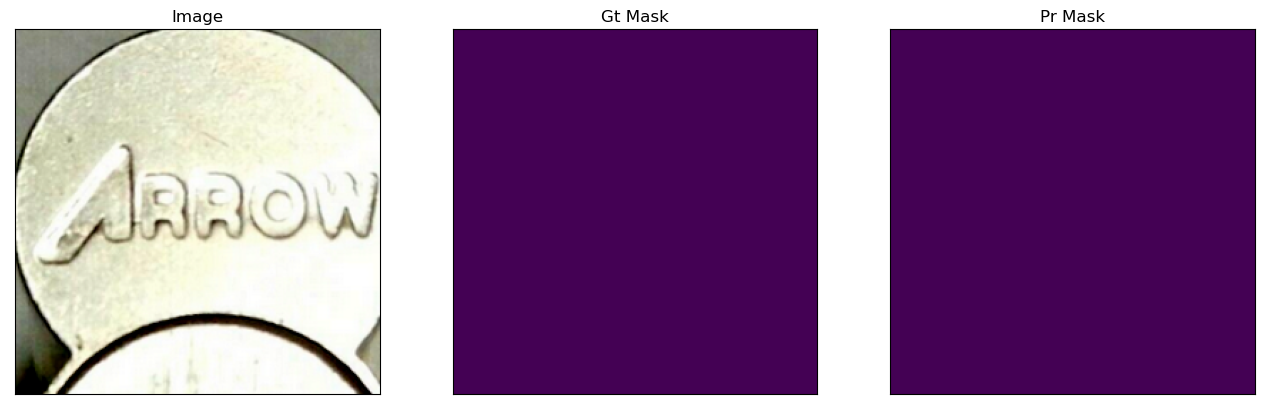

1/1 [==============================] - 0s 80ms/step


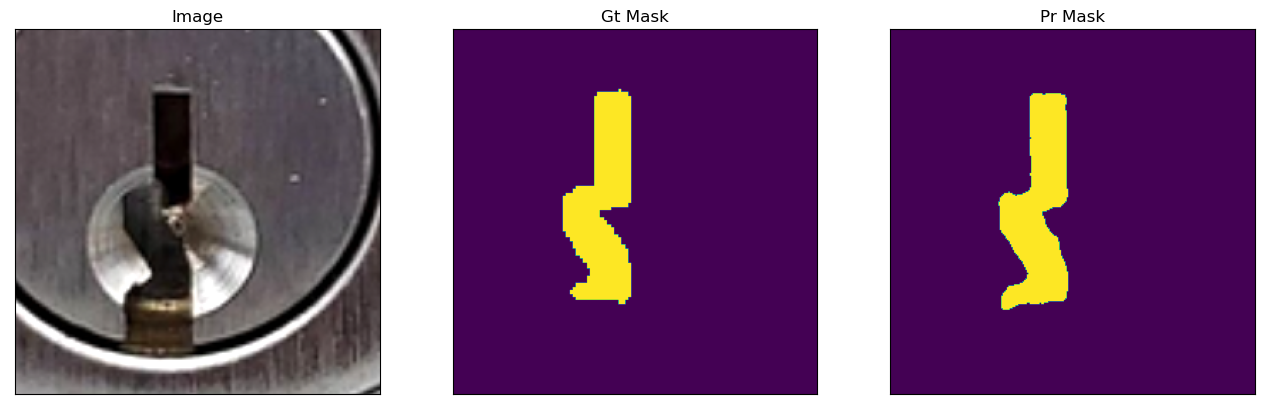

1/1 [==============================] - 0s 91ms/step


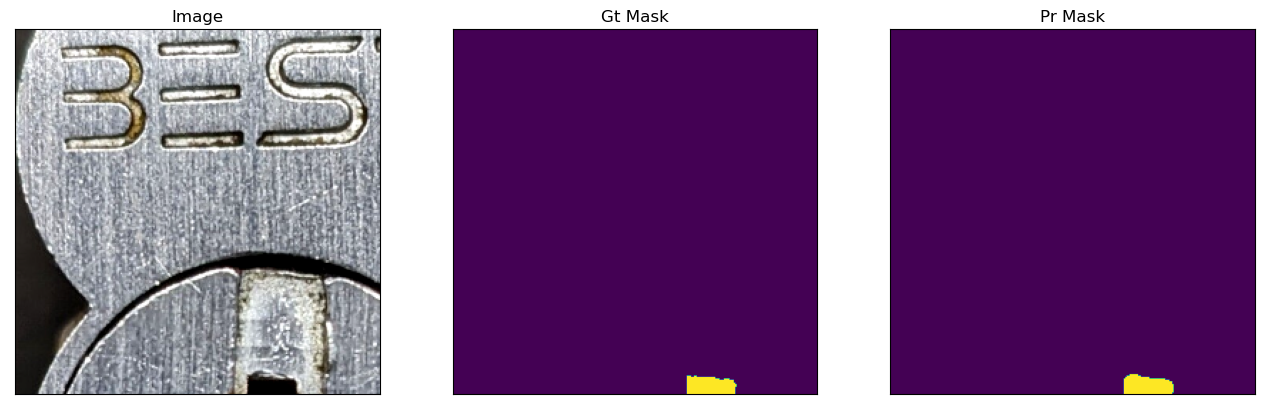

1/1 [==============================] - 0s 80ms/step


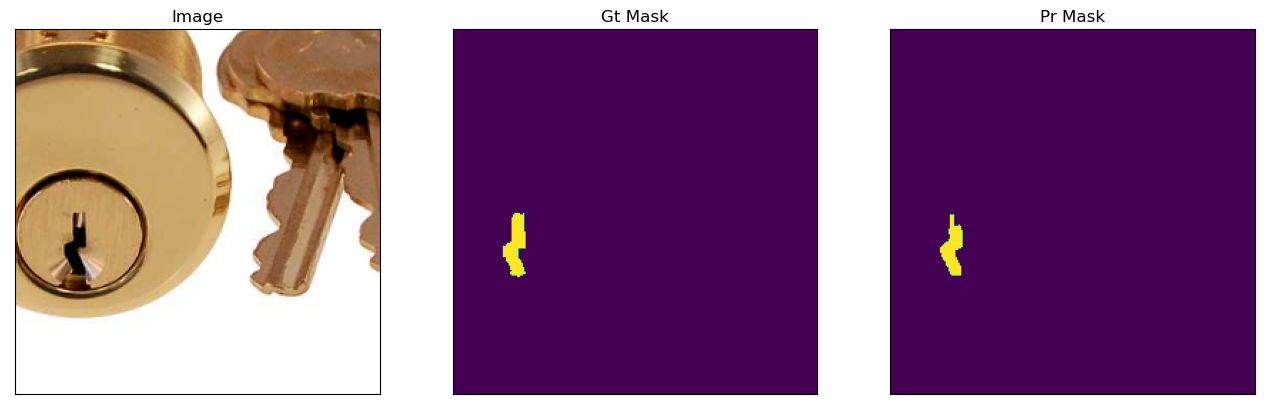

1/1 [==============================] - 0s 78ms/step


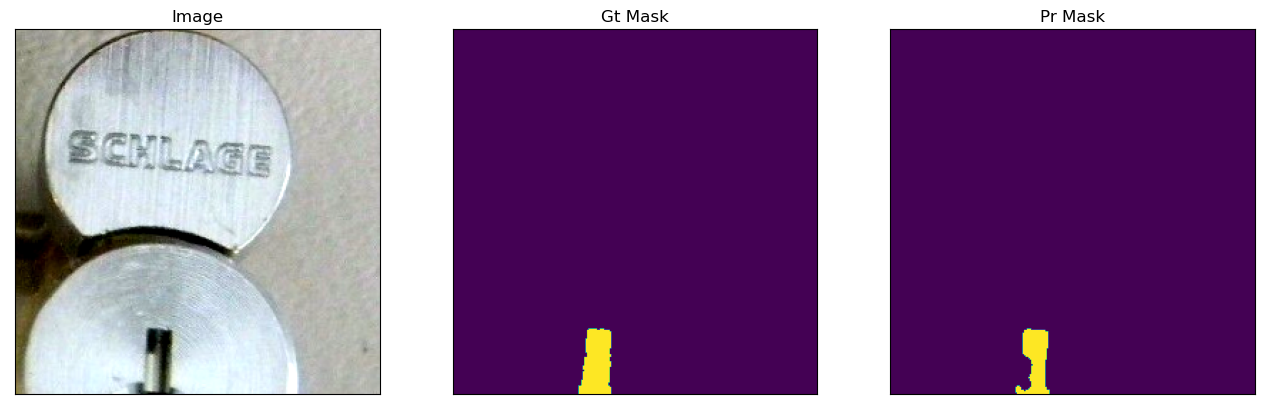

1/1 [==============================] - 0s 78ms/step


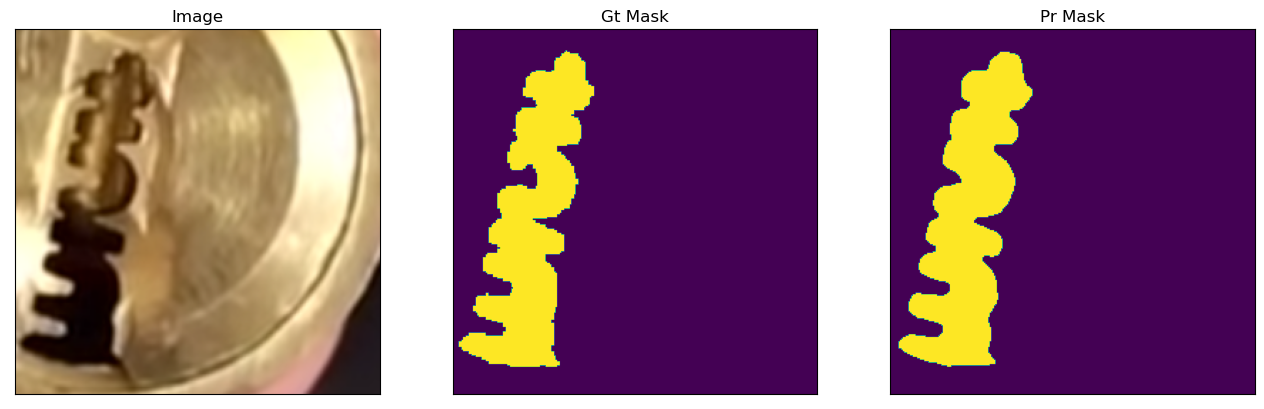

1/1 [==============================] - 0s 79ms/step


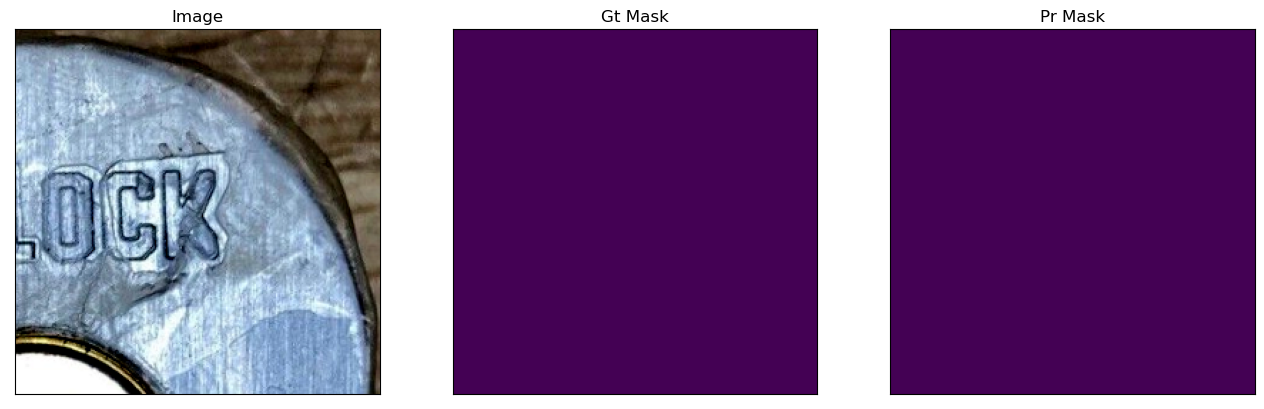

1/1 [==============================] - 0s 74ms/step


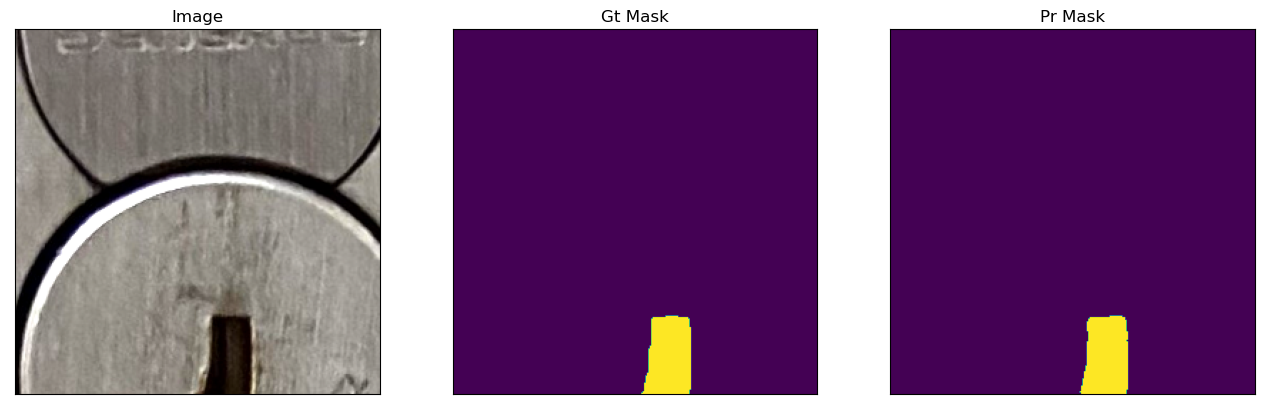

1/1 [==============================] - 0s 76ms/step


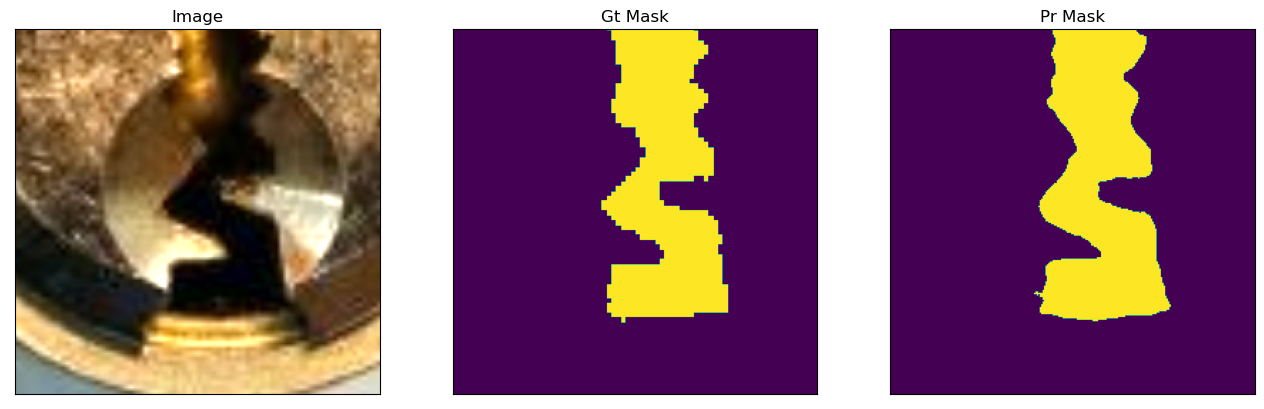

1/1 [==============================] - 0s 83ms/step


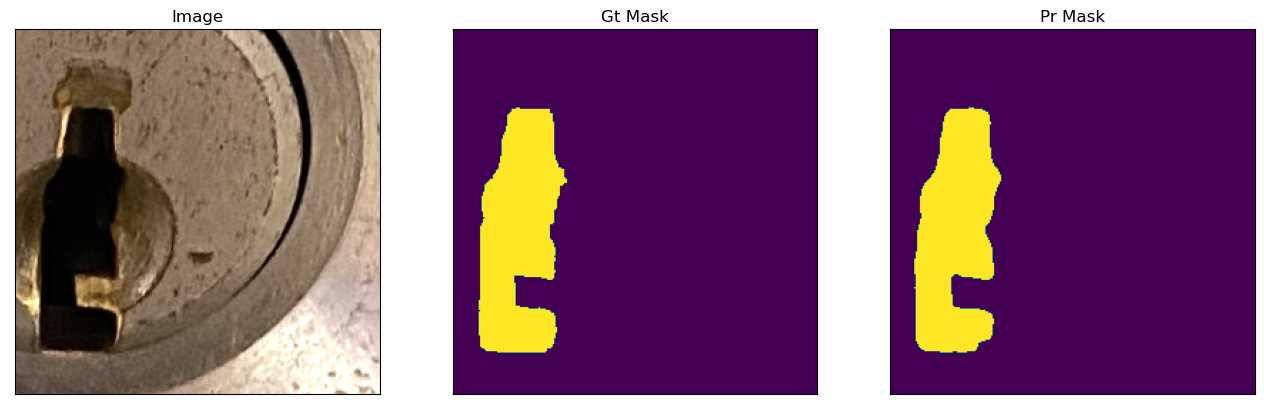

1/1 [==============================] - 0s 80ms/step


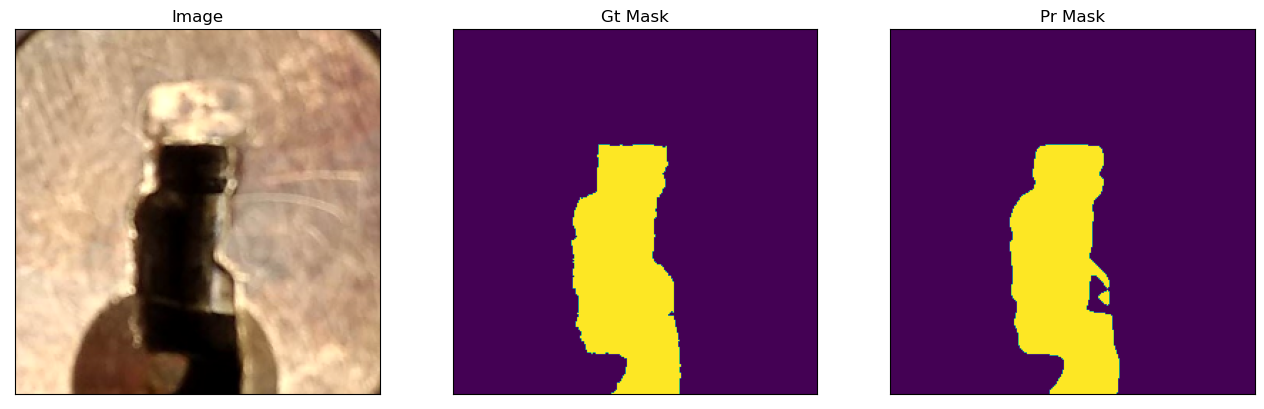

1/1 [==============================] - 0s 88ms/step


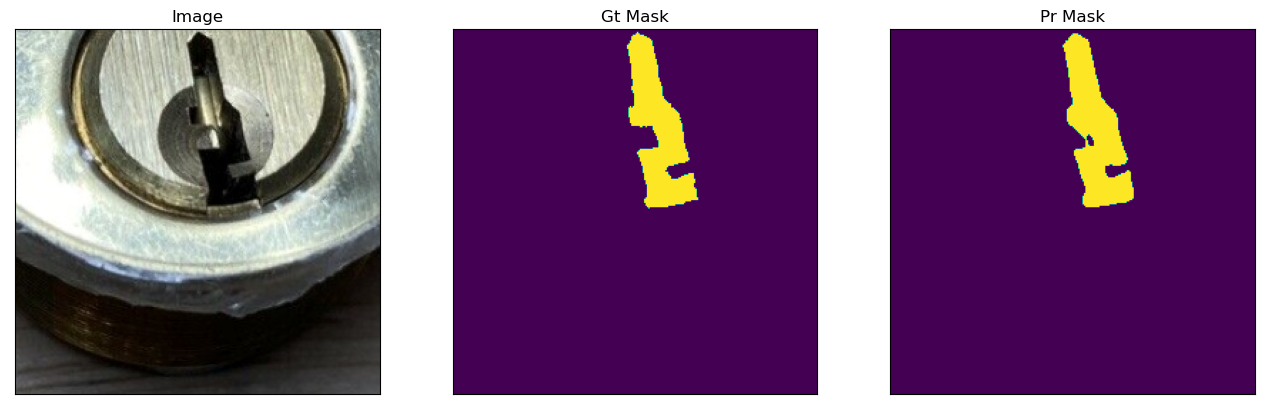

1/1 [==============================] - 0s 72ms/step


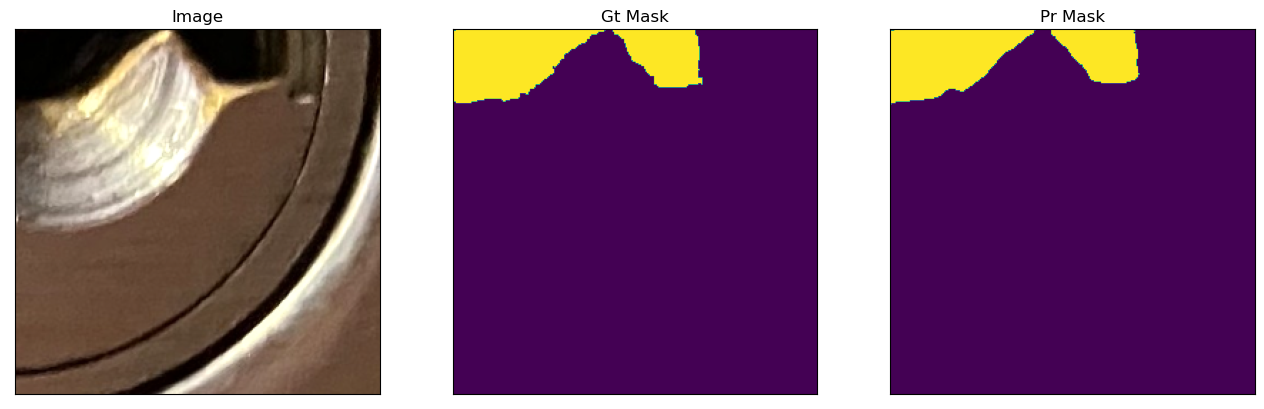

1/1 [==============================] - 0s 110ms/step


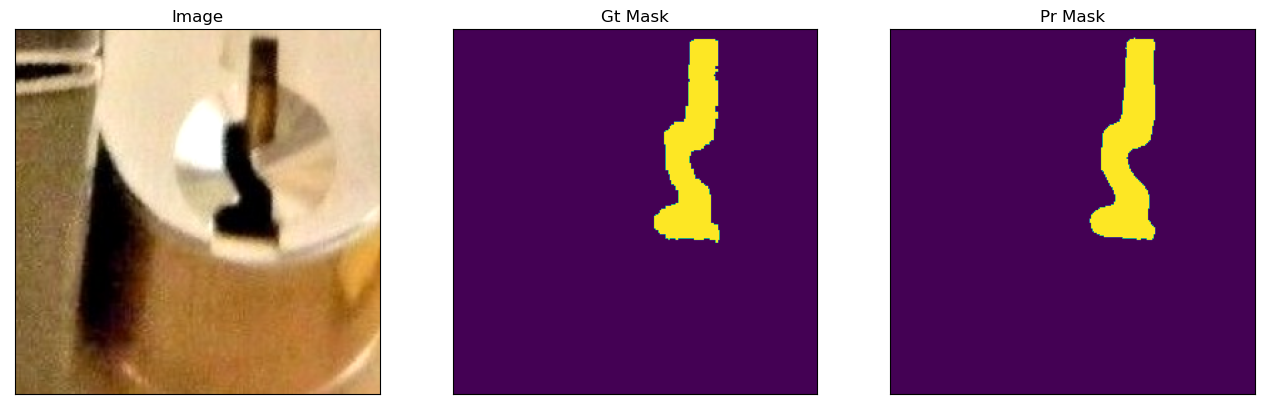

1/1 [==============================] - 0s 125ms/step


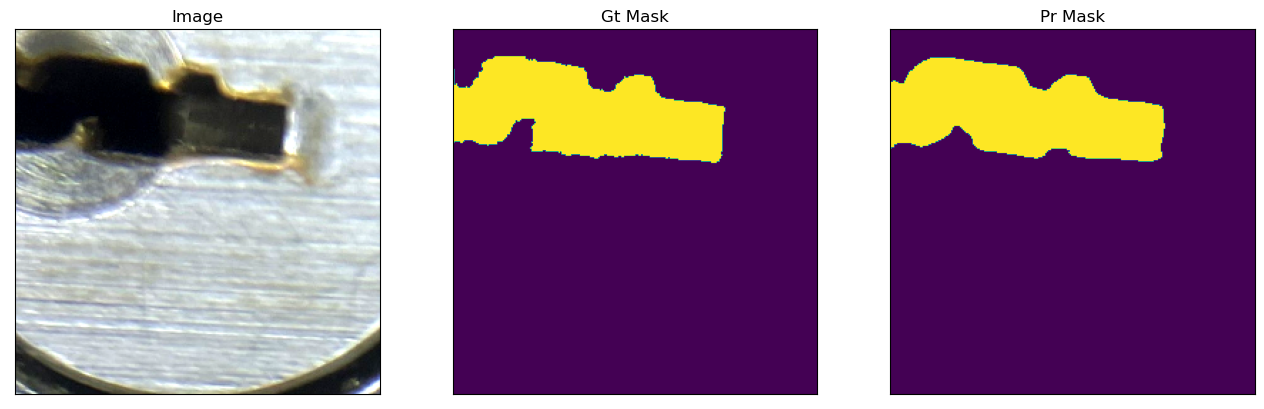

1/1 [==============================] - 0s 140ms/step


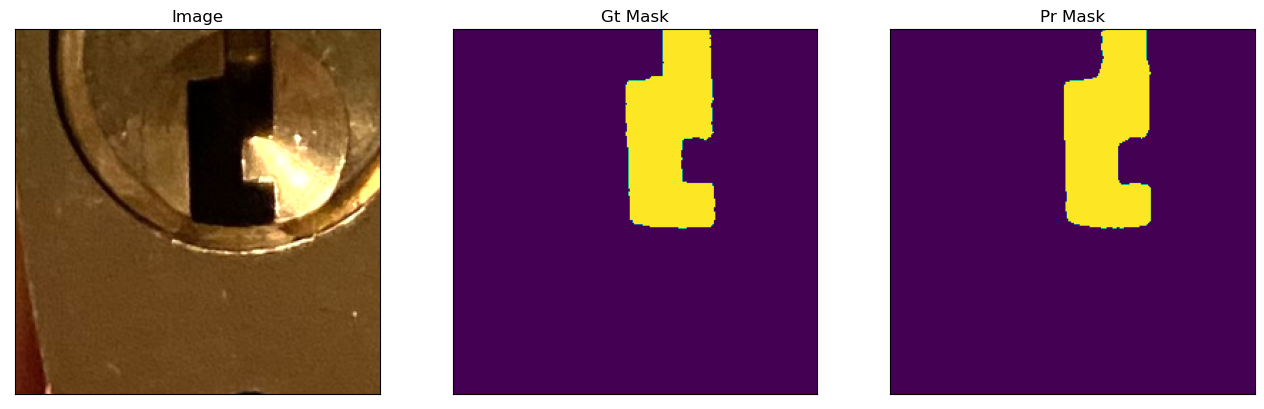

1/1 [==============================] - 0s 156ms/step


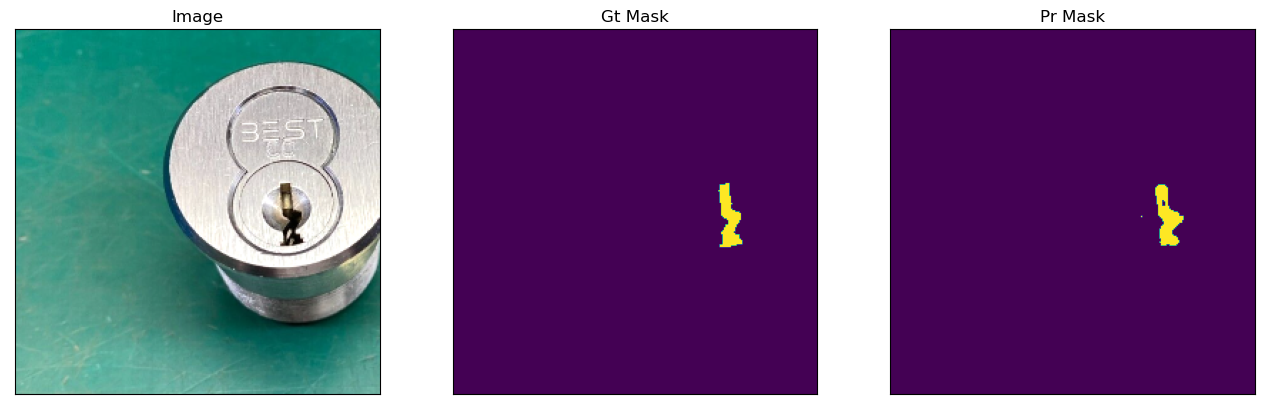

1/1 [==============================] - 0s 157ms/step


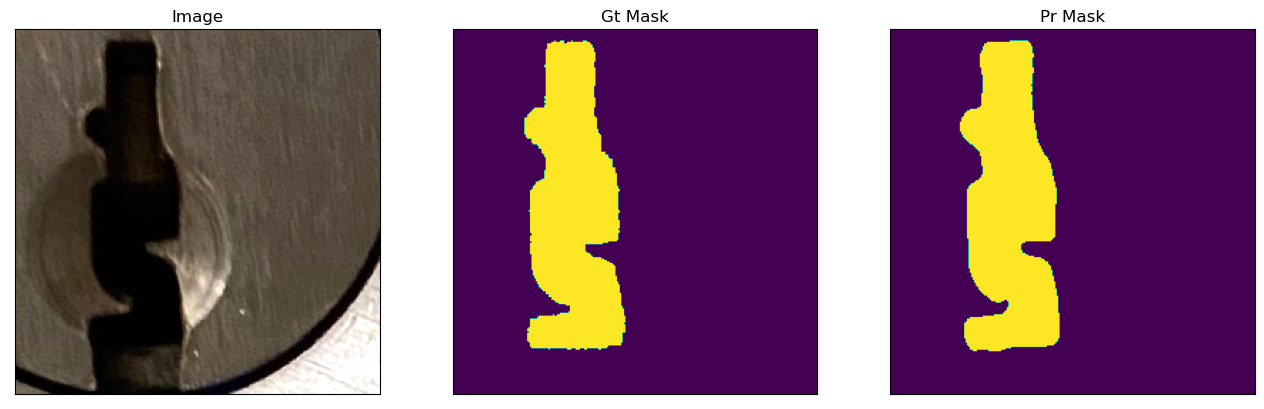

1/1 [==============================] - 0s 169ms/step


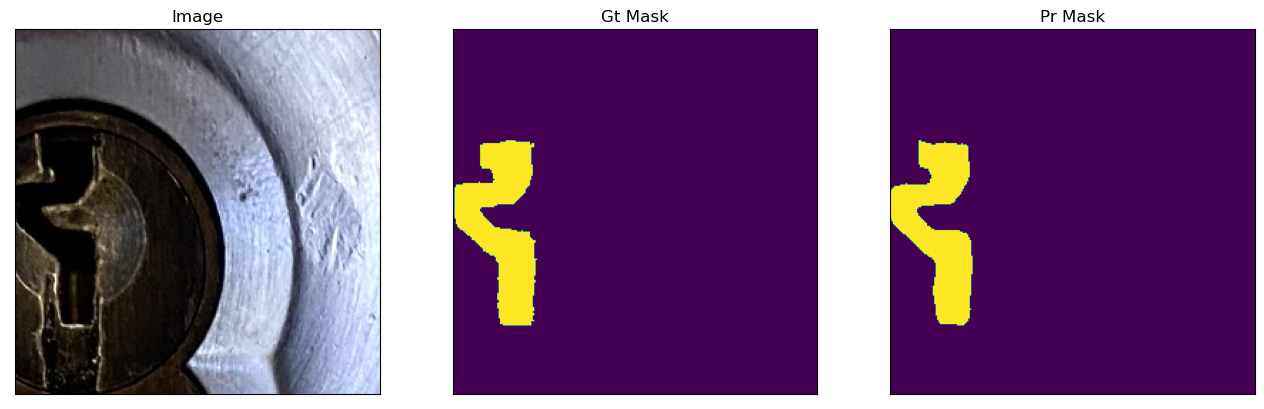

1/1 [==============================] - 0s 175ms/step


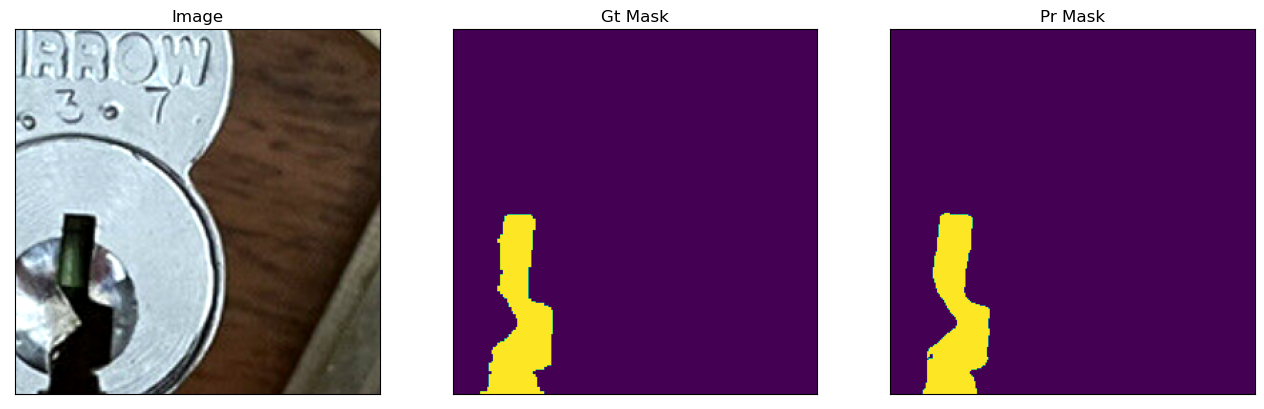

In [23]:
for i in range(len(test_dataset)):
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )

